In [30]:
# read in each file/ROI
# plot the coloc channel intensity for the detected spots
# plot the coloc channel intensity for the randomly placed spots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from skimage import filters
import numpy as np
import os

usr=os.path.expanduser('~')
home_dir = f"{usr}/Dropbox (NYU Langone Health)/mac_files"
img_dir = "holtlab/data_and_results/LINE1/ORF1-ORF1 Colocalization"

df = pd.read_csv(f"{home_dir}/{img_dir}/results/ORF1-561-all_spots.txt", sep='\t', index_col=0)
df_random = pd.read_csv(f"{home_dir}/{img_dir}/results/ORF1-561-all_random_spots.txt", sep='\t', index_col=0)
coloc_ch_col='coloc_ch1_intensity'
coloc_ch_col='coloc_ch3_intensity'

In [31]:
# add normalization to the table.  
# median of random spots for each file/roi/location separately

df['norm_factor']=0
for file_name in df_random.file_name.unique():
    cur_df = df_random[df_random.file_name == file_name]
    for roi in cur_df.roi.unique():
        cur_roi_df = cur_df[cur_df.roi == roi]
        med=np.median(cur_roi_df[coloc_ch_col])
            
        df.loc[(df.roi==roi) & (df.file_name==file_name), 'norm_factor'] = med
        df_random.loc[(df_random.roi==roi) & (df_random.file_name==file_name), 'norm_factor'] = med
        
df[f"{coloc_ch_col}-norm"]=df[coloc_ch_col]/df['norm_factor']
df_random[f"{coloc_ch_col}-norm"]=df_random[coloc_ch_col]/df_random['norm_factor']

In [15]:
# Save as a new file
df.to_csv(f"{home_dir}/{img_dir}/results/ORF1-561-all_spots-NORM.txt", sep='\t')
df_random.to_csv(f"{home_dir}/{img_dir}/results/ORF1-561-all_random_spots-NORM.txt", sep='\t')

In [16]:
# add ave intensity random spots vs ave intensity detected spots for each ROI
ReplicateAverages = df[df['roi']!=''].groupby(['file_name','roi'], as_index=False).agg({coloc_ch_col: np.mean})
ReplicateAverages['type']='detected'
ReplicateAverages['id']=ReplicateAverages['file_name']+"-"+ReplicateAverages['roi']
ReplicateAverages=ReplicateAverages[['id','type',coloc_ch_col]]

ReplicateAveragesRandom = df_random[df_random['roi']!=''].groupby(['file_name','roi'], 
                                                                  as_index=False).agg({coloc_ch_col: np.mean})
ReplicateAveragesRandom['type']='random'
ReplicateAveragesRandom['id']=ReplicateAveragesRandom['file_name']+"-"+ReplicateAveragesRandom['roi']
ReplicateAveragesRandom=ReplicateAveragesRandom[['id','type',coloc_ch_col]]

In [17]:
summary_data = pd.concat([ReplicateAverages, ReplicateAveragesRandom],axis=0)

1.0534281645436691e-13


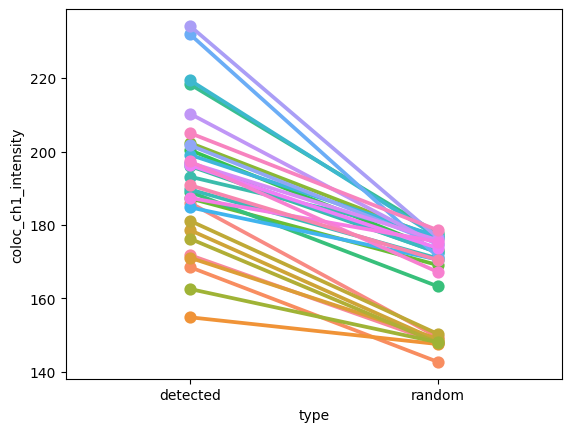

In [18]:
from scipy import stats

statistic, pvalue = stats.ttest_rel(ReplicateAverages[coloc_ch_col], 
                                    ReplicateAveragesRandom[coloc_ch_col])
print(pvalue)

# Make plot 
ax=sns.pointplot(x="type", y=coloc_ch_col, hue="id", data=summary_data)
ax.legend_.remove()
plt.savefig(f"{home_dir}/{img_dir}/results/results-mean-int-lineplot.pdf")

In [19]:
def plot_intensity_kde(df, df_random, file_name, location, normalize, nrows, ncols, size):

    if(location != ''):
        cur_df = df[df.location==location]
        cur_df_random = df_random[df_random.location==location]
    else:
        cur_df = df
        cur_df_random = df_random
        
    cur_df = cur_df[cur_df.file_name==file_name]
    cur_random_df = cur_df_random[cur_df_random.file_name==file_name]

    fig,axs=plt.subplots(nrows, ncols, figsize=size)
    i=0; j=0
    for roi in cur_df.roi.unique():
        data = cur_df[cur_df.roi==roi][coloc_ch_col]
        data_random = cur_random_df[cur_random_df.roi==roi][coloc_ch_col]

        if(roi != '' and len(data)>0):
            #sns.histplot(x=data, ax=axs[i][j], #stat='probability', 
            #             bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)
            #sns.histplot(x=data_random, ax=axs[i][j], #stat='probability', 
            #             bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)
            
            
            if(normalize):
                norm_factor=np.median(data_random)
            else:
                norm_factor=1
                
            sns.kdeplot(x=data_random/norm_factor, ax=axs[i][j], label='random spots')
            sns.kdeplot(x=data/norm_factor, ax=axs[i][j], label='detected spots')
            
            m1=round(np.mean(data_random),2)
            m2=round(np.mean(data),2)
            axs[i][j].set_title(f"{roi} ({len(data)} | {len(data_random)}) ({round(norm_factor,2)})\n({m1} | {m2})")
            
            if(i == 0 and j == 0):
                axs[i][j].legend()

            if(j == (ncols-1)):
                i+=1; j=0
            else:
                j+=1
    plt.tight_layout()
    plt.show()

In [20]:
def plot_intensity_kde2(df, df_random, file_name):
    
    fig,axs=plt.subplots(1, 3, figsize=(12,3))

    cur_df = df[df.file_name==file_name]
    cur_random_df = df_random[df_random.file_name==file_name]
    
    i=0
    for location in ['all','nuclear','cytoplasmic']:
        if(location != 'all'):
            cur_loc_df = cur_df[cur_df.location==location]
            cur_loc_df_random = cur_random_df[cur_random_df.location==location]
        else:
            cur_loc_df = cur_df
            cur_loc_df_random = cur_random_df
    
        data = cur_loc_df[coloc_ch_col]
        data_random = cur_loc_df_random[coloc_ch_col]
                    
        sns.kdeplot(x=data_random, ax=axs[i], label='random spots')
        sns.kdeplot(x=data, ax=axs[i], label='detected spots')
            
        axs[i].set_title(f"{location}: ({len(data)} {len(data_random)})")
        axs[i].legend()
        
        i += 1

    plt.tight_layout()
    plt.show()

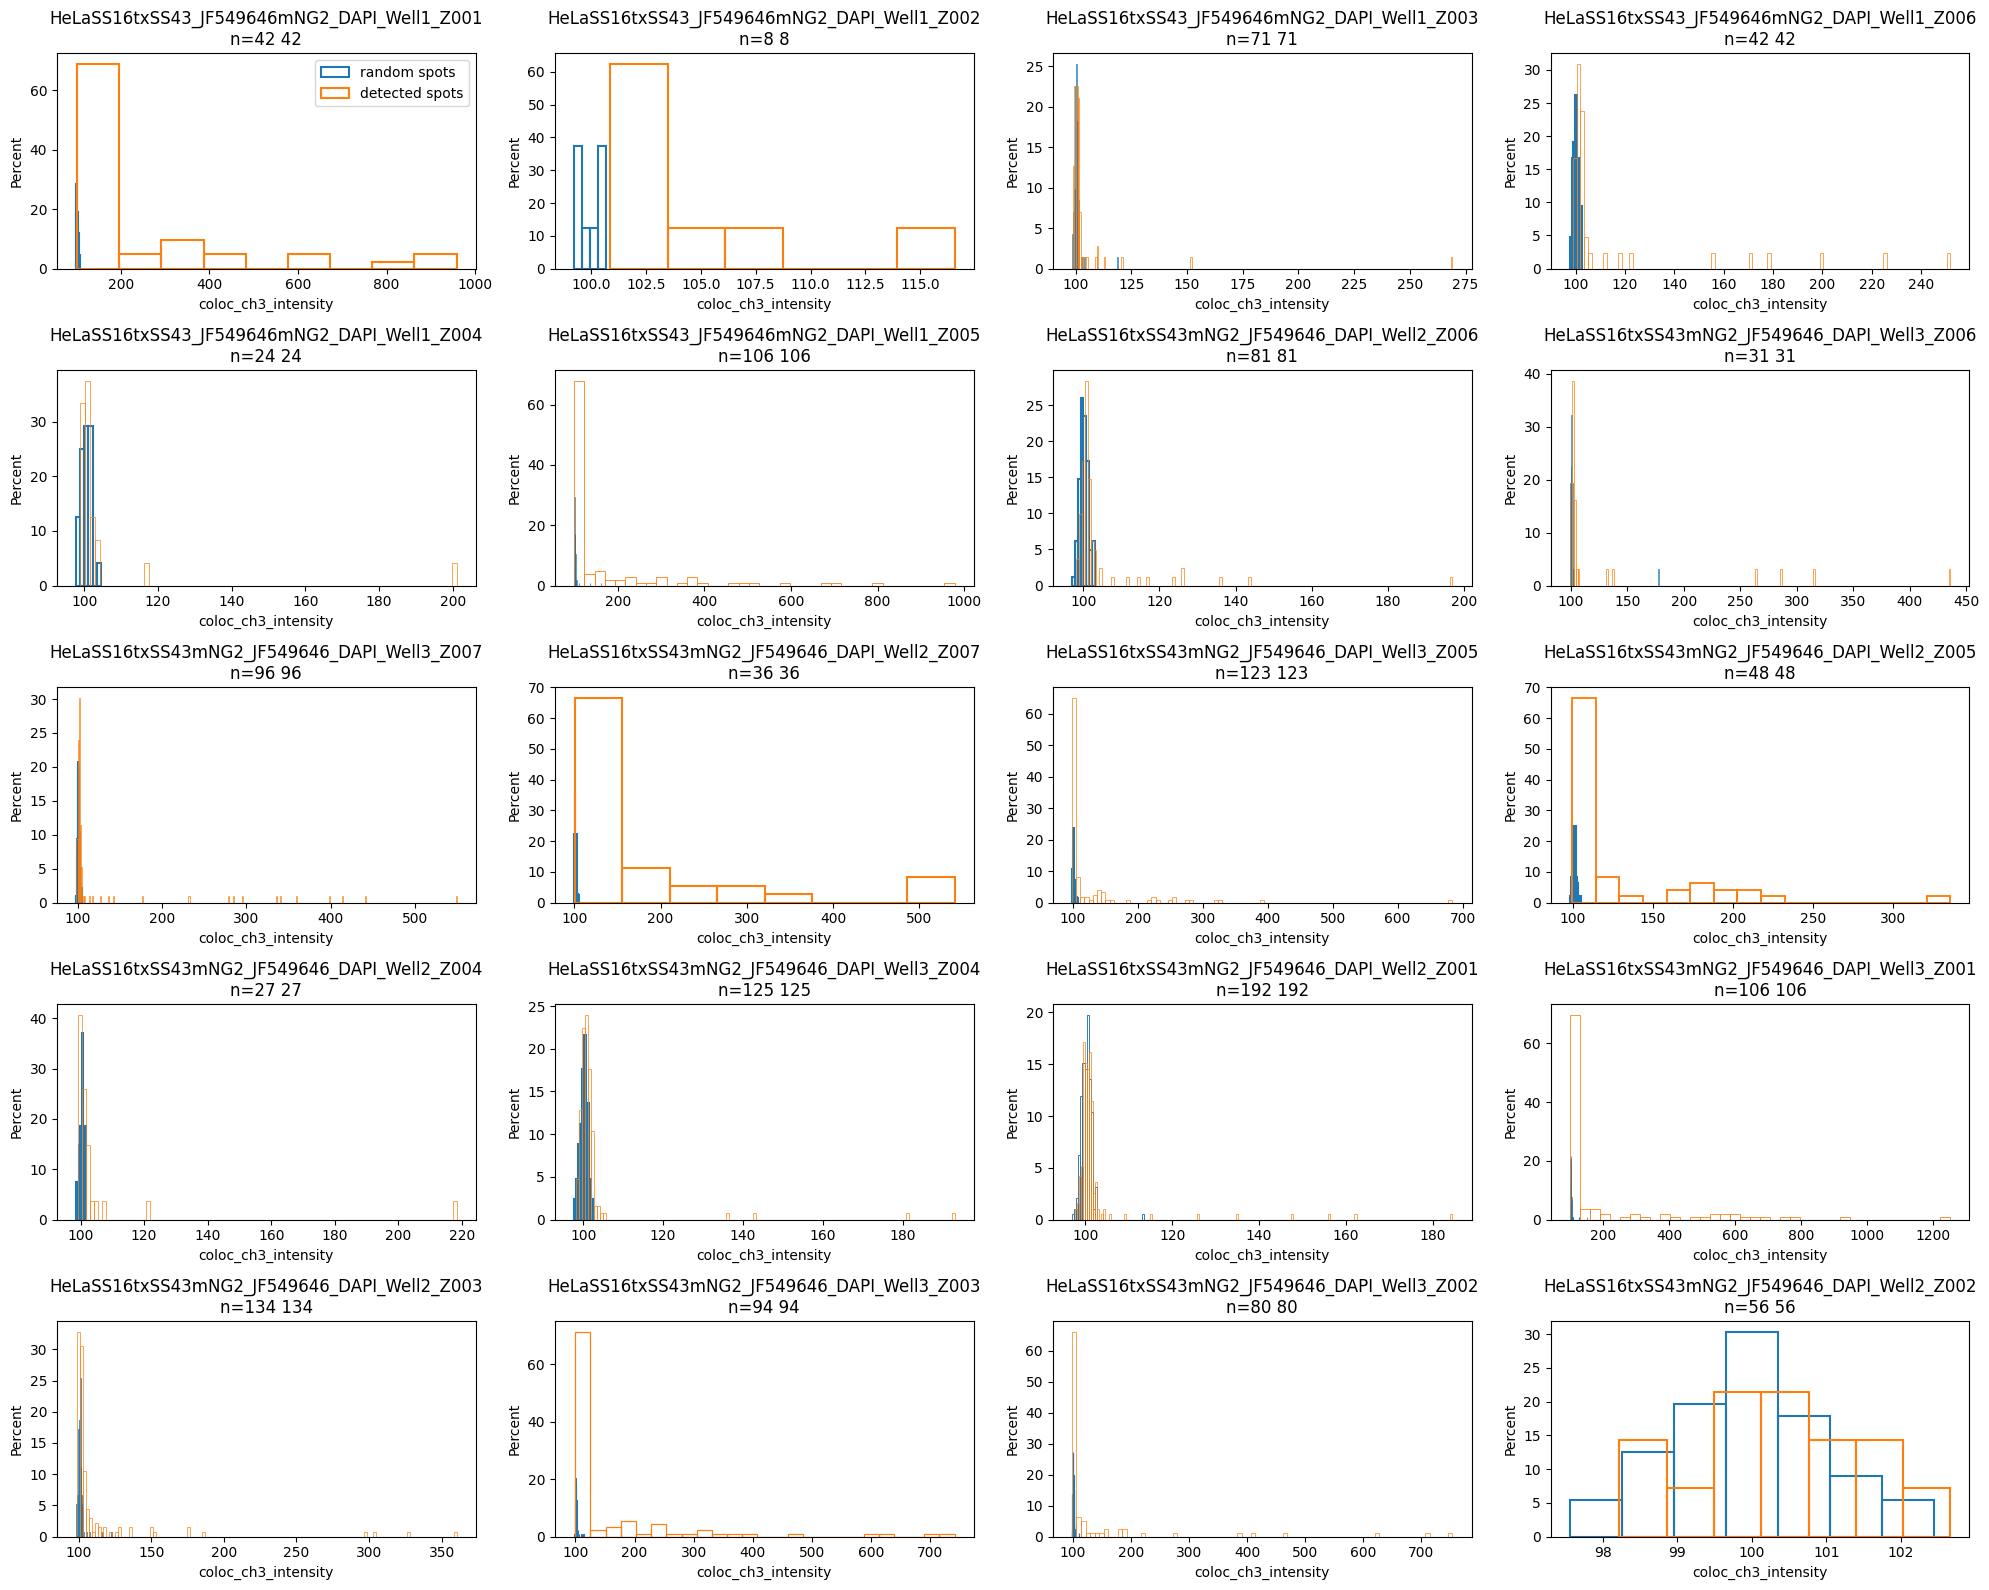

In [34]:
fig,axs=plt.subplots(5, 4, figsize=(20,16)) #, sharex=True, sharey=True)
ncols=4
i=0; j=0
for file_name in df.file_name.unique():
    cur_df = df[df.file_name==file_name]
    cur_random_df = df_random[df_random.file_name==file_name]

    data = cur_df[coloc_ch_col]
    data_random = cur_random_df[coloc_ch_col]

    #sns.kdeplot(x=data_random, ax=axs[i][j], label='random spots')
    #sns.kdeplot(x=data, ax=axs[i][j], label='detected spots')
    
    sns.histplot(x=data_random, ax=axs[i][j], label='random spots', #element="step", 
                 fill=False, stat="percent") #, bins=np.arange(70,300,10))
    sns.histplot(x=data, ax=axs[i][j], label='detected spots', #element="step", 
                 fill=False, stat="percent") #, bins=np.arange(70,300,10))

    axs[i][j].set_title(f"{file_name}\nn={len(data)} {len(data_random)}")
    if(i==0 and j==0):
        axs[i][j].legend()
    
    if(j == (ncols-1)):
        i+=1; j=0
    else:
        j+=1

plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/results/results-kde.pdf")
plt.show()

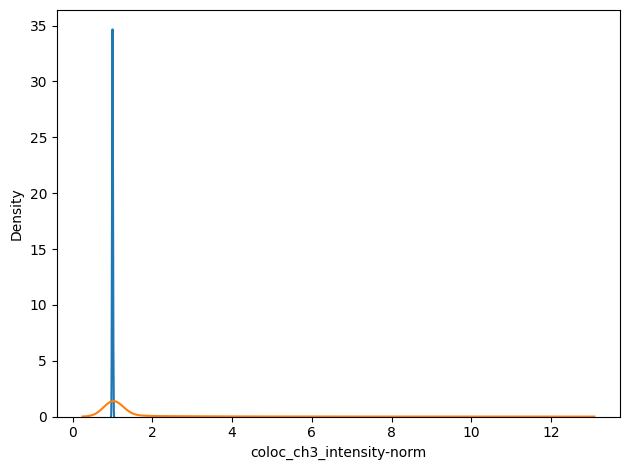

In [36]:

cur_df = df
cur_df_random = df_random

data = cur_df[f"{coloc_ch_col}-norm"]
data_random = cur_random_df[f"{coloc_ch_col}-norm"]

sns.kdeplot(x=data_random, label='random spots')
sns.kdeplot(x=data, label='detected spots')


plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/results/results-kde-all-norm.pdf")
plt.show()

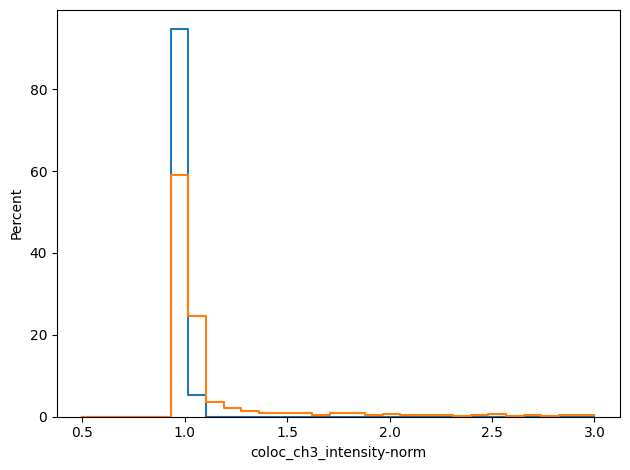

In [38]:
loc='cytoplasmic'
cur_df = df
cur_df_random = df_random

data = cur_df[f"{coloc_ch_col}-norm"]
data_random = cur_random_df[f"{coloc_ch_col}-norm"]

#sns.kdeplot(x=data_random, label='random spots')
#sns.kdeplot(x=data, label='detected spots')
    
sns.histplot(x=data_random, label='random spots', element="step", 
             fill=False, stat="percent", bins=np.linspace(0.5,3,30))
sns.histplot(x=data, label='detected spots', element="step", 
             fill=False, stat="percent", bins=np.linspace(0.5,3,30))

plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/results/results-hist-all-norm.pdf")
plt.show()

In [ ]:
for file_name in df_dox.file_name.unique():
    print(file_name)
    print(len(df_dox[df_dox.file_name==file_name]['roi'].unique()))

In [ ]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_001', 'cytoplasmic', False, 2, 3, (10,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_001', 'nuclear', False, 2, 3, (10,6))

In [ ]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_002', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_002', 'nuclear', False, 2, 2, (7,6))

In [ ]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_003', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_003', 'nuclear', False, 2, 2, (7,6))

In [ ]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_004', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_004', 'nuclear', False, 2, 2, (7,6))

In [ ]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_005', 'cytoplasmic', False, 3, 3, (10,8))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_005', 'nuclear', False, 3, 3, (10,8))

In [ ]:
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_001')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_002')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_003')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_004')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_005')